In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/LICENSE
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/.gitignore
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/areeg-starter.ipynb
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/README.md
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/requirements.txt
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/dataloader.py
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/CITATION.cff
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/Utilities/Preprocessing.py
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main/Utilities/__init__.py
/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-mai

In [2]:
!ls /kaggle/input


arabic-eeg-sessions  areeg-library


In [3]:
!ls /kaggle/input/areeg-library


ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main


In [4]:
import os, sys

# Add ArEEG main folder to sys.path (not the ArEEG subfolder)
sys.path.append('/kaggle/input/areeg-library/ArEEG-an-Open-Access-Arabic-Inner-Speech-EEG-Dataset-main')

# Test import
from Utilities.Extractor import process_eeg
print("✅ ArEEG library imported successfully and ready!")


✅ ArEEG library imported successfully and ready!


In [5]:
import numpy as np
import os
from Utilities.Extractor import process_eeg

# ======================================
# STEP 1: Define dataset directory
# ======================================
# This folder contains all recorded EEG sessions for each subject
directory = "/kaggle/input/arabic-eeg-sessions/RecordedSessions"

# Number of samples per trial and the target EEG states (classes)
TIME_STEPS = 1200
included_states = ["Up", "Down", "Left", "Right", "Select"]

# Empty lists to collect all subjects' data
X_all, Y_all = [], []

# ======================================
# STEP 2: Loop through each subject folder
# ======================================
for folder in os.listdir(directory):
    subject_folder = os.path.join(directory, folder)
    if not os.path.isdir(subject_folder):
        continue

    print(f"📁 Processing {folder} ...")
    try:
        # Extract EEG trials and labels for this subject
        X, Y = process_eeg(
            TIME_STEPS=TIME_STEPS,
            included_states=included_states,
            subject_folder=subject_folder
        )

        print(f"   ✅ {len(Y)} valid trials | Labels: {set(Y)}")
        X_all.append(X)
        Y_all.append(Y)
    except Exception as e:
        print(f"   ⚠️ Skipped {folder} due to error: {e}")

# ======================================
# STEP 3: Combine all subjects into one dataset
# ======================================
X_all = np.concatenate(X_all, axis=0)
Y_all = np.concatenate(Y_all, axis=0)

print("\n✅ Files loaded successfully!")
print(f"📁 X_all shape: {X_all.shape}  (Trials, Channels, Time)")
print(f"📁 Y_all shape: {Y_all.shape}")
print("🎯 Unique labels:", np.unique(Y_all))

# ======================================
# STEP 4: Save arrays for later use
# ======================================
np.save("/kaggle/working/X_all.npy", X_all)
np.save("/kaggle/working/Y_all.npy", Y_all)


📁 Processing sub3 ...
   ✅ 542 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub0 ...
   ✅ 375 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub4 ...
   ✅ 375 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub10 ...
   ✅ 350 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub7 ...
   ✅ 364 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub8 ...
   ✅ 375 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub9 ...
   ✅ 375 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub5 ...
   ✅ 375 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub1 ...
   ✅ 375 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub6 ...
   ✅ 375 valid trials | Labels: {'Right', 'Select', 'Left', 'Down', 'Up'}
📁 Processing sub2 ...
   ✅ 350 valid tr

In [6]:
# ======================================
# STEP 1: Save EEG data arrays
# ======================================
import numpy as np
import shutil

# Save both numpy arrays to the working directory
np.save("/kaggle/working/X_all.npy", X_all)
np.save("/kaggle/working/Y_all.npy", Y_all)

print("✅ EEG data saved as .npy files in /kaggle/working")

# ======================================
# STEP 2: Compress for download
# ======================================
# Zip both saved files into a single archive
shutil.make_archive("/kaggle/working/EEG_dataset", 'zip', "/kaggle/working")

print("📦 EEG_dataset.zip is ready for download!")


✅ EEG data saved as .npy files in /kaggle/working
📦 EEG_dataset.zip is ready for download!


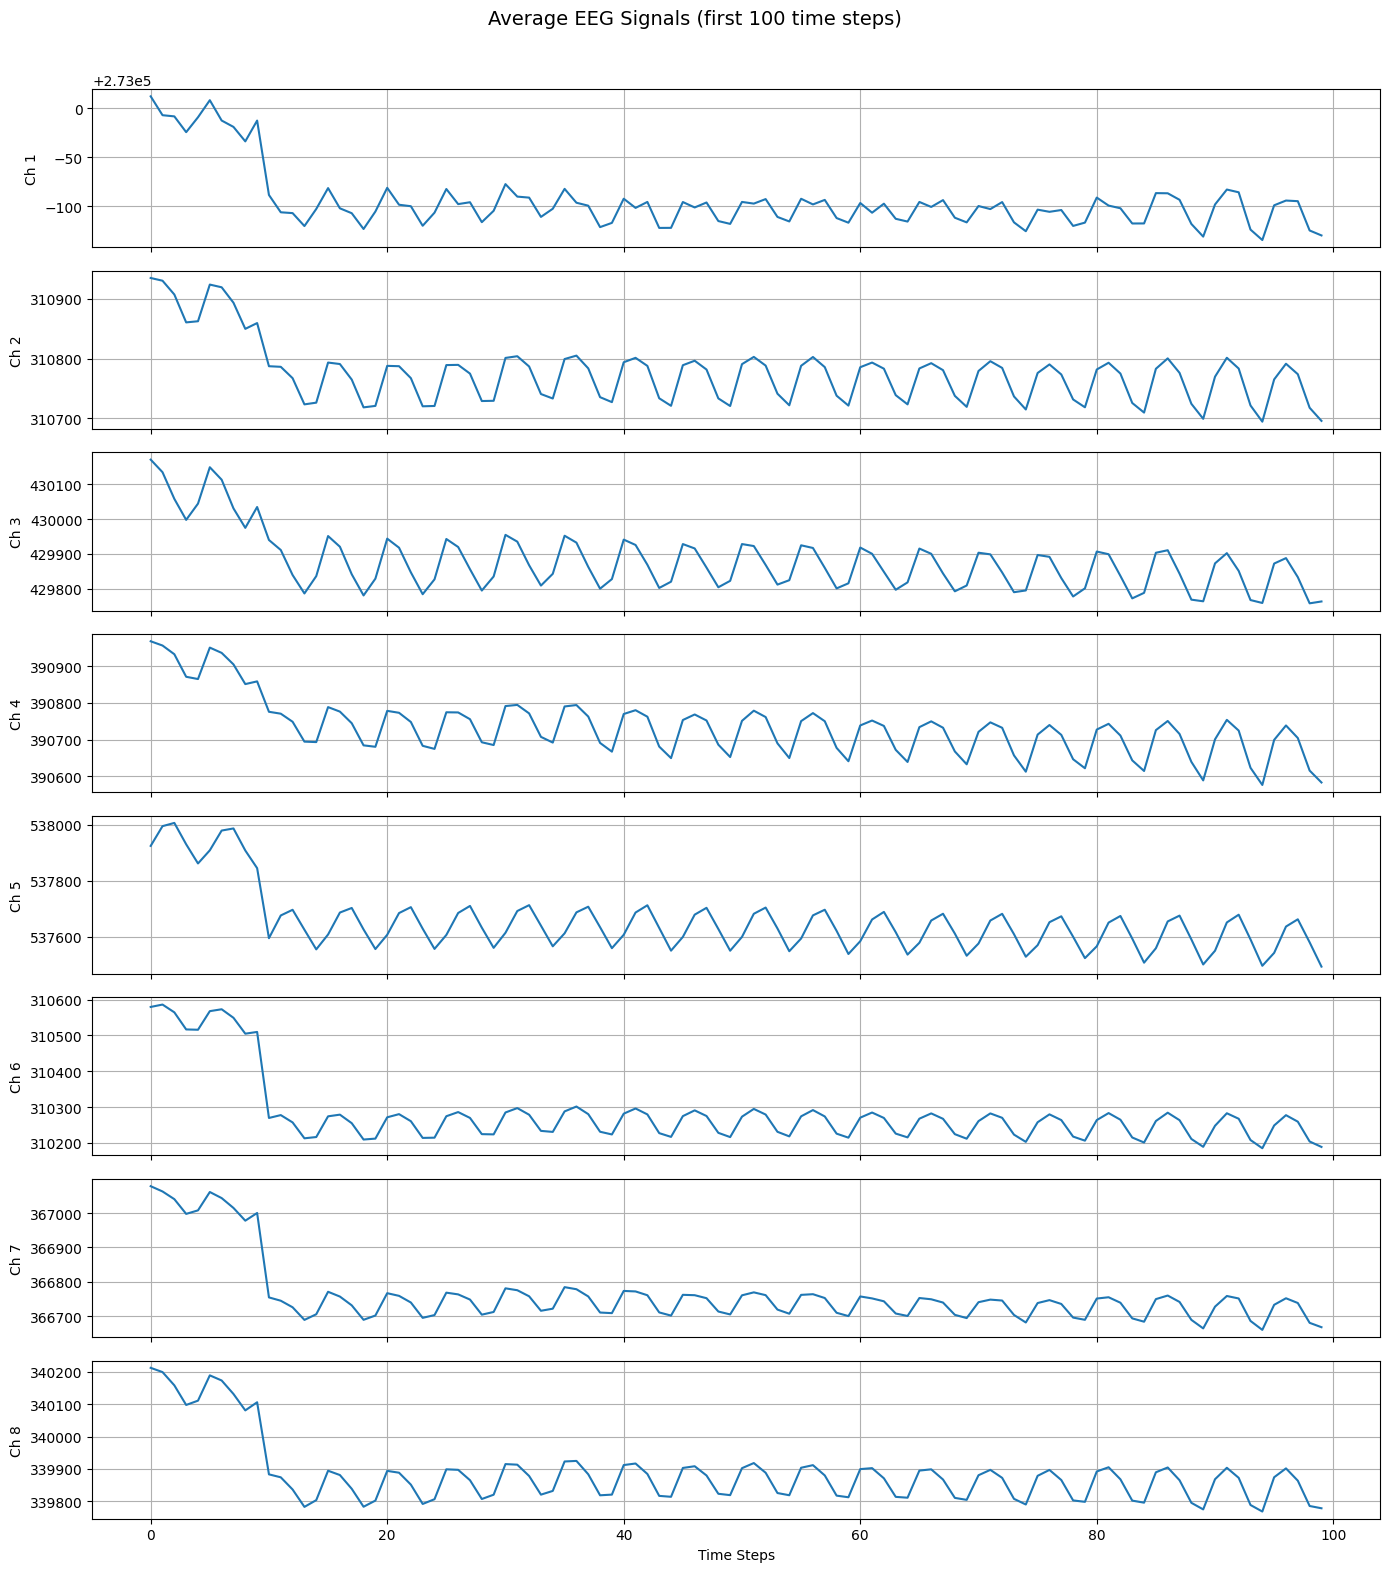

In [7]:
# ======================================
# STEP 3: Visualize EEG signals
# ======================================
import numpy as np
import matplotlib.pyplot as plt

# Load saved data (optional if already loaded)
# X_all = np.load("/kaggle/working/X_all.npy", allow_pickle=True)
# Y_all = np.load("/kaggle/working/Y_all.npy", allow_pickle=True)

# Compute the mean signal across all trials (average EEG per channel)
mean_signal = X_all.mean(axis=0)  # shape (8, 1200)

# Define how many timesteps to display
ts = 100  # you can change it to 200, 500, etc.
timesteps = np.arange(ts)

# Create figure with 8 subplots (for 8 EEG channels)
fig, axes = plt.subplots(8, 1, figsize=(14, 16), sharex=True)

# Plot each EEG channel separately
for ch in range(mean_signal.shape[0]):
    axes[ch].plot(timesteps, mean_signal[ch, :ts])
    axes[ch].set_ylabel(f'Ch {ch+1}')
    axes[ch].grid(True)

# Add common labels and title
axes[-1].set_xlabel('Time Steps')
fig.suptitle('Average EEG Signals (first 100 time steps)', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [8]:
# ======================================
# STEP 4: Split data into Train/Test sets
# ======================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode text labels ('Up', 'Down', etc.) into numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_all)

# Split into 80% training and 20% testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_all, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded
)

# Print shapes
print("✅ Data split successfully!")
print(f"Train shape: {X_train.shape},  Test shape: {X_test.shape}")
print(f"Train labels: {len(Y_train)},  Test labels: {len(Y_test)}")
print(f"Unique encoded labels: {label_encoder.classes_}")


✅ Data split successfully!
Train shape: (3684, 8, 1200),  Test shape: (922, 8, 1200)
Train labels: 3684,  Test labels: 922
Unique encoded labels: ['Down' 'Left' 'Right' 'Select' 'Up']
